- 앞서 Chapter 02. 에서 토큰을 추출해 빈도를 세고 분류하는 방법을 살펴봤음.
- 이런 토큰들로 다른 일을 해보자.
    - **주어진 단어가 특정 문서 or 말뭉치 전체에서 얼마나 중요한지 측정**해보자. 단어의 중요도 Check.
    - 긍정성 점수나 분류명이 있다면 그런 **단어들이 등장한 횟수를 나머지 모든 문서와 비교해 점수를 매겨**보자.

<br>

- 앞서 얻었었던 이진 비트 벡터 형태로 표현하는 것이 아닌, **의미가 있는 연속된 값**들로 바꿔보자.
    - 단어들이 이제 이산 공간이 아닌 **연속 공간에서 표현**.
    - 뭐가 좋나? **좀 더 다양한 수학 도구들을 이용해 단어 표현을 다룰 수 있음**.
    - 최종 목표는 **단어의 중요도 or 단어의 정보 내용을 반영한 수치 표현을 찾는 것**.
        - 이번 장에선 **단어의 중요도를 반영하는 수치 표현**을 자세히 볼 것.
        - Chapter 04. 에서는 수치로 표현한 단어 정보를 가지고 단어의 의미를 수량화 할 것.

<br>

용어 하나 짚고 넘어가자.  <br>
**TF-IDF 벡터** : 단어의 중요도를 좀 더 잘 표현하는 단어 점수 벡터.

<br>

- 빈도(도수)에 기초한다는 점에서 **통계적 모형**에 해당.

# 단어 모음

<br>

- 앞서 텍스트들을 통해 간단한 벡터 공간 모형을 만들었음.
    - one-hot 같은 방법을 통해 이진 단어 모음(bag of words)을 만들고,
    - 이 벡터를 DataFrame에 담아 문서 검색을 위한 index를 만들었음.
- 단어 출현 횟수가 어떻게 도움이 되는지 예제를 한번 보자.

In [3]:
from nltk.tokenize import TreebankWordTokenizer
from collections import Counter # Counter 같은걸 bag or multiset 자료구조 라 부르기도 함.

sentence = """The faster Harry got to the store, the faster Harry, the faster, would get home."""
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(sentence.lower())

print(tokens)

bag_of_words = Counter(tokens)
bag_of_words

['the', 'faster', 'harry', 'got', 'to', 'the', 'store', ',', 'the', 'faster', 'harry', ',', 'the', 'faster', ',', 'would', 'get', 'home', '.']


Counter({'the': 4,
         'faster': 3,
         'harry': 2,
         'got': 1,
         'to': 1,
         'store': 1,
         ',': 3,
         'would': 1,
         'get': 1,
         'home': 1,
         '.': 1})

    Dict형태라 순서가 좀 뒤죽박죽.
    key 순서는 단순히 저장, 갱신, 조회에 최적화. 일관된 출력 고려X.
    그래서 기존 문장에 있던 단어 순서정보는 사라짐.
    
    빈도수 정렬을 위한 most_common이라는 메서드가 있음.

In [4]:
bag_of_words.most_common(4) # 가장 많이 출현한 4개 출력

[('the', 4), ('faster', 3), (',', 3), ('harry', 2)]

- **어떤 단어가 한 문서에 출현한 횟수**를 **용어 빈도(term frequency, TF)**라 함.
- 응용에 따라선 *TF를 해당 문서에 있는 모든 단어의 수로 나눠 정규화 하기도 함.*

<br>

- 4개의 토큰 중 **정관사 the와 문장부호 , 는 문장에 대한 정보를 많이 담고있지 않음**. **불용어**.
- 가장 자주 등장한 토큰은 faster와 harry가 될 것.
- Counter 객체 bag_of_words에서 harry의 TF를 조회해, 전체 토큰 수로 정규화 해보자.

In [5]:
times_harry_appears = bag_of_words['harry']
num_unique_words = len(bag_of_words) # 원 문장에 있는 고유한 단어의 수
tf = times_harry_appears / num_unique_words
round(tf, 4)

0.1818

- **정규화 된 용어 빈도(TF)**가 뭘까.
    - **단어의 출현 횟수를 문서의 길이로 "길들인" 것**. 왜 길들여야 할까?
    - dog라는 단어가 A문서에선 3번 등장하고, B문서에선 100번 등장한다 해보자.
    - ***dog라는 단어가 B에서 더 중요하다 볼 수 있을까?*** 무조건 그렇진 않을 것. A와 B 문서 길이가 다를 수 있음.
    - **단어가 포함된 문서의 길이도 고려해 단어의 중요도를 추정**할 필요가 있다.
    - 이게 바로 정규화 된 용어 빈도.
- 이렇게 **정규화된 TF는 주어진 단어가 그 문서에서 상대적으로 얼마나 중요한지도 말해줌.**
    - 앞선 예시에서 harry의 속도가 중요함을 유추해 볼 수 있음.
    - 이진값보다 출현 횟수가 단어 의미를 파악하는데 더 도움이 된다는 점을 알 수 있음.
- 긴 문서를 사용한 예시를 봐보자.

In [6]:
from collections import Counter
from nltk.tokenize import TreebankWordTokenizer
from nlpia.data.loaders import kite_text

tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(kite_text.lower())
tokenCounts = Counter(tokens)
tokenCounts

C:\Users\skdbs\Anaconda3\lib\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
C:\Users\skdbs\Anaconda3\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
C:\Users\skdbs\Anaconda3\lib\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
C:\Users\skdbs\Anaconda3\lib\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  np = pd.np
INFO:nlpia.constants:Startin

Counter({'a': 20,
         'kite': 16,
         'is': 7,
         'traditionally': 1,
         'tethered': 2,
         'heavier-than-air': 1,
         'craft': 2,
         'with': 2,
         'wing': 5,
         'surfaces': 1,
         'that': 2,
         'react': 1,
         'against': 1,
         'the': 26,
         'air': 2,
         'to': 5,
         'create': 1,
         'lift': 4,
         'and': 10,
         'drag.': 1,
         'consists': 2,
         'of': 10,
         'wings': 1,
         ',': 15,
         'tethers': 2,
         'anchors.': 2,
         'kites': 8,
         'often': 2,
         'have': 4,
         'bridle': 2,
         'guide': 1,
         'face': 1,
         'at': 3,
         'correct': 1,
         'angle': 1,
         'so': 3,
         'wind': 2,
         'can': 3,
         'it.': 1,
         "'s": 2,
         'also': 3,
         'may': 4,
         'be': 5,
         'designed': 2,
         'not': 1,
         'needed': 1,
         ';': 2,
         'when': 2,


    상위 토큰에 불용어가 많이 보임. a, is 같은거.
    불용어 제거하자.

In [7]:
import nltk
nltk.download('stopwords', quiet=True)

True

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
tokens = [x for x in tokens if x not in stopwords]
kite_counts = Counter(tokens)
kite_counts, kite_counts.most_common(5)

(Counter({'kite': 16,
          'traditionally': 1,
          'tethered': 2,
          'heavier-than-air': 1,
          'craft': 2,
          'wing': 5,
          'surfaces': 1,
          'react': 1,
          'air': 2,
          'create': 1,
          'lift': 4,
          'drag.': 1,
          'consists': 2,
          'wings': 1,
          ',': 15,
          'tethers': 2,
          'anchors.': 2,
          'kites': 8,
          'often': 2,
          'bridle': 2,
          'guide': 1,
          'face': 1,
          'correct': 1,
          'angle': 1,
          'wind': 2,
          'it.': 1,
          "'s": 2,
          'also': 3,
          'may': 4,
          'designed': 2,
          'needed': 1,
          ';': 2,
          'kiting': 3,
          'sailplane': 1,
          'launch': 1,
          'tether': 1,
          'meets': 1,
          'single': 1,
          'point.': 1,
          'fixed': 1,
          'moving': 2,
          'untraditionally': 1,
          'technical': 2,
          

    kite, wing, lift 가 문서에서 중요한 단어임을 유추해 볼 수 있음.
    다른 문서에서도 이와 비슷한 TF가 나오면, 해당 말뭉치의 모든 문서가
    연이나 연날리기에 관한 문서일 가능성이 있다.
    
    그러면 아마 모든 문서가 string과 wind를 자주 언급할 것이며, 
    모든 문서에서 string의 TF와 wind의 TF가 높게 나올 것.
    
    이런 수치들을 수학 연산에 좀 더 적합한 형태로 바꿔보자.

# Vectorization

<br>

- 수치들을 Dict에 담아두기만 했음. 활용할 건덕지가 많지 않다.
- 문서를 표현하는 TF를 벡터로 만들어보자.
- Dict구조에 담긴 TF들로 하나의 정규화된 TF벡터를 생성하는 예시를 한번 봐보자.

In [10]:
document_vector = []
doc_length = len(tokens)
for key, value in kite_counts.most_common():
    document_vector.append(value / doc_length)
document_vector

[0.07207207207207207,
 0.06756756756756757,
 0.036036036036036036,
 0.02252252252252252,
 0.018018018018018018,
 0.018018018018018018,
 0.013513513513513514,
 0.013513513513513514,
 0.013513513513513514,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.009009009009009009,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.0045045045045045045,
 0.

    수학 연산을 위한 새 문서를 추가하고, 어휘집을 만들어보자.

In [11]:
docs = ["""The faster Harry got to the store, the faster Harry, the faster, would get home."""]
docs.append("""Harry is hairy and faster than Jill.""")
docs.append("""Jill is not as hairy as Harry.""")
docs

['The faster Harry got to the store, the faster Harry, the faster, would get home.',
 'Harry is hairy and faster than Jill.',
 'Jill is not as hairy as Harry.']

In [14]:
doc_tokens = []
for doc in docs:
    doc_tokens += [sorted(tokenizer.tokenize(doc.lower()))]

"""
doc_tokens

[[',',
  ',',
  ',',
  '.',
  'faster',
  'faster',
  'faster',
  'get',
  'got',
  'harry',
  'harry',
  'home',
  'store',
  'the',
  'the',
  'the',
  'the',
  'to',
  'would'],
 ['.', 'and', 'faster', 'hairy', 'harry', 'is', 'jill', 'than'],
 ['.', 'as', 'as', 'hairy', 'harry', 'is', 'jill', 'not']]
"""
all_doc_tokens = sum(doc_tokens, []) # 토큰 전부 합치기
lexicon = sorted(set(all_doc_tokens)) # 어휘사전 구축
lexicon

[',',
 '.',
 'and',
 'as',
 'faster',
 'get',
 'got',
 'hairy',
 'harry',
 'home',
 'is',
 'jill',
 'not',
 'store',
 'than',
 'the',
 'to',
 'would']

- 문서를 표현하는 벡터의 길이는 항상 어휘집의 단어 수와 같아야 함.
- 벡터의 한 성분의 위치는 어휘집 안에서의 그 성분에 대응되는 토큰의 위치와 일치해야 함.

In [16]:
from collections import OrderedDict

zero_vector = OrderedDict((token, 0) for token in lexicon)
zero_vector

OrderedDict([(',', 0),
             ('.', 0),
             ('and', 0),
             ('as', 0),
             ('faster', 0),
             ('get', 0),
             ('got', 0),
             ('hairy', 0),
             ('harry', 0),
             ('home', 0),
             ('is', 0),
             ('jill', 0),
             ('not', 0),
             ('store', 0),
             ('than', 0),
             ('the', 0),
             ('to', 0),
             ('would', 0)])

- 말뭉치의 문서마다 기준 벡터를 복사해, 각 성분을 해당 용어 빈도TF로 갱신해 세 문서의 벡터를 생성한다.

In [18]:
import copy

doc_vectors = []
for doc in docs:
    vec = copy.copy(zero_vector) # 벡터를 복사해 독립적인 벡터 생성.
    tokens = tokenizer.tokenize(doc.lower())
    token_counts = Counter(tokens)
    for key, value in token_counts.items():
        vec[key] = value / len(lexicon)
    doc_vectors.append(vec)
doc_vectors

[OrderedDict([(',', 0.16666666666666666),
              ('.', 0.05555555555555555),
              ('and', 0),
              ('as', 0),
              ('faster', 0.16666666666666666),
              ('get', 0.05555555555555555),
              ('got', 0.05555555555555555),
              ('hairy', 0),
              ('harry', 0.1111111111111111),
              ('home', 0.05555555555555555),
              ('is', 0),
              ('jill', 0),
              ('not', 0),
              ('store', 0.05555555555555555),
              ('than', 0),
              ('the', 0.2222222222222222),
              ('to', 0.05555555555555555),
              ('would', 0.05555555555555555)]),
 OrderedDict([(',', 0),
              ('.', 0.05555555555555555),
              ('and', 0.05555555555555555),
              ('as', 0),
              ('faster', 0.05555555555555555),
              ('get', 0),
              ('got', 0),
              ('hairy', 0.05555555555555555),
              ('harry', 0.05555555555555555),
 

    이 벡터들을 어떻게 활용할 수 있을까?
    코사인 유사도를 통해 문서 간 유사도 측정을 할 수 있을 것.
    다른말로, 벡터에 적용되는 여러 수학 연산을 사용할 수 있음.

## Vector Space

<br>

- **벡터**는 **순서 있는 수치 목록**. 수치들은 벡터 공간에서 벡터의 위치를 말해주는 **좌표성분**으로 볼 수 있음.
    - **하나의 벡터는 공간의 한 장소(위치)를 나타냄**.
    - or, 벡터로 방향이나 속력, 두 위치사이의 거리를 나타낼 수도 있음.
- **벡터공간**은 그 **공간 안에 나타날 수 있는 모든 가능한 벡터의 집합**.
    - **벡터의 성분 갯수는 해당 벡터 공간의 차원 수**.
    - 성분이 2개인 벡터는 2차원 벡터 공간에 놓이고, 3개인 벡터는 3차원 벡터 공간에 놓인다.
- 여기서 다룰 벡터공간은 *공간의 모든 축이 직선이고 서로 직교하는 유클리드 공간*에 존재.

<br>

- 자연어 문서에서 **벡터 공간의 차원 수**는 **전체 말뭉치에 등장하는 고유한 단어들의 개수**.
    - TF 벡터나 TF-IDF 벡터를 다룰 땐 이 **고유 단어 수를 대문자 $K$**로 표현.
    - 고유 단어 수는 말뭉치의 어휘(vocabulary)크기이기도 하므로, $|V|$로 표현하기도 함.
- 정리하면, **말뭉치의 모든 문서는 $K$차원 벡터 공간의 $K$차원 벡터들로 표현된다.**
    - 앞서 봤던 Harry 문서의 경우는 $K=18$.

<br>

- 문서를 하나의 공간을 기준으로 한 벡터로 표현하면 문서들의 유사도를 수치로 계산할 수 있음.
- 두 벡터간의 거리는 한 벡터의 머리에서 다른 벡터의 머리까지의 거리. 이를 2-norm 거리라고 함.
- 하지만 **단어 출현 횟수 벡터(TF 벡터)들은 이런식으로 거리를 측정하면 안됨.**

<br>

- 서로 가까운 (거리가 짧은) 두 벡터는 서로 비슷하다 고 할 수 있고, ***두 문서의 벡터 표현들이 비슷하면 두 문서는 서로 비슷하다고 볼 수 있음***.
- 하지만 벡터 거리 정의에 따르면, **벡터가 가르키는 방향이 비슷할수록, 두 벡터의 길이가 비슷할수록 두 벡터의 거리가 줄어듦.**
    - *비슷한 길이의 두 문서에서 얻은 TF벡터들은 길이가 비슷할 것이며, 두 벡터간 거리가 짧게 나옴.*
    - 뭐가 문제냐? **두 문서의 길이가 같다고 해서 두 문서가 비슷한건 아님.**
    - 그럼? **비슷한 단어들을 비슷한 빈도로 사용했는지를 측정**하는 것이 더 바람직. 
    - 여기서 필요한게? **각도 $\theta$**. ***이를 이용해 유사도를 측정***할 수 있음. 이것이 바로 **코사인 유사도**.
    
    \begin{aligned}
    A \cdot B &= |A| |B| * \cos(\theta) \\
    \cos(\theta) &= \frac{A \cdot B}{|A| |B|} \\
    \end{aligned}
    
- 유사도의 범위는 -1 ~ +1 까지.

    코사인 유사도를 계산하는 함수를 만들어서 써보자.
    (나중에 패키지로 쓰지만, 원리는 알고 넘어가보자.)

In [20]:
import math

def cosine_sim(vec1, vec2):
    vec1 = [val for val in vec1.values()]
    vec2 = [val for val in vec2.values()]
    dot_prod = 0
    
    # 내적 계산
    for i, v in enumerate(vec1):
        dot_prod += v * vec2[i]
    # 노름 계산
    mag_1 = math.sqrt(sum([x**2 for x in vec1]))
    mag_2 = math.sqrt(sum([x**2 for x in vec2]))
    
    # 유사도 계산
    return dot_prod / (mag_1 * mag_2)

- 두 벡터의 내적은 더 짧은 벡터를 긴 벡터에 수직으로 투영해 나온 벡터의 길이이기도 함.
    - 벡터가 같은 방향을 가리킬수록 내적값은 큰 양수, 반대일수록 큰 음수값.
    - **코사인 유사도는 이런 내적을 길이에 맞게 정규화 한 것.**
        - **유사도가 1**이라는 의미는 **두 벡터가 모든 차원에서 완전히 같은방향**을 가르킨다는 의미.
        - **유사도가 0**이라는 의미는 **두 벡터에 공통점이 없다**는 의미. **모든 차원에서 수직**.
            - NLP의 경우 **두 문서에 공통으로 출현하는 단어가 하나도 없으면 해당 TF벡터가 0**이 됨.
            - 그러면 **두 문서는 주제나 내용이 상당히 다를 가능성이 큼.**
        - **유사도가 -1**이라는 의미는 **두 벡터가 완전히 다른 방향**. 두 벡터중 하나가 다른 사분면에 있는 경우.
            - 근데 ***TF벡터들은 같은 사분면에 있으므로 이런 일(음수값이 나오는 현상)은 안생김.***

## Zipf's Law (지프의 법칙)

<br>

- **단어의 출현 횟수**는 통계학에서 다루는 **빈도**에 해당.
- **지프의 법칙?** 수학적 통계를 바탕으로 밝혀진 경험적 법칙. 물리 및 사회 과학 분야에서 연구된 많은 종류의 정보들이 지프 분포에 가까운 경향을 보인다는 것을 의미.

> 어떤 **자연어 말뭉치 표현에 나타나는 단어**들을 그 **사용 빈도가 높은 순서대로 나열**했을 때,  <br> 
> **모든 단어의 사용 빈도는 해당 단어의 순위에 반비례** 한다.

- *빈도순으로 1위인 단어는 2위인 단어보다 2배 더 자주쓰이고, 3위인 단어보다 3배 더 자주쓰인다.*
- 말뭉치나 문서의 단어 빈도와 빈도순 단어 순위를 그래프로 그려보면 **순위-빈도 쌍들이 아래로 구부러진 반비례 곡선을 따라 배치**되어 있음.
    - 이 곡선의 두 축에 로그를 취하면 **기울기가 음수인 직선 그래프를 형성**하게 될 것.
    - **직선에서 크게 벗어난 순위-빈도쌍은 이상치**. 조사해볼 만한 가치가 있을 것.

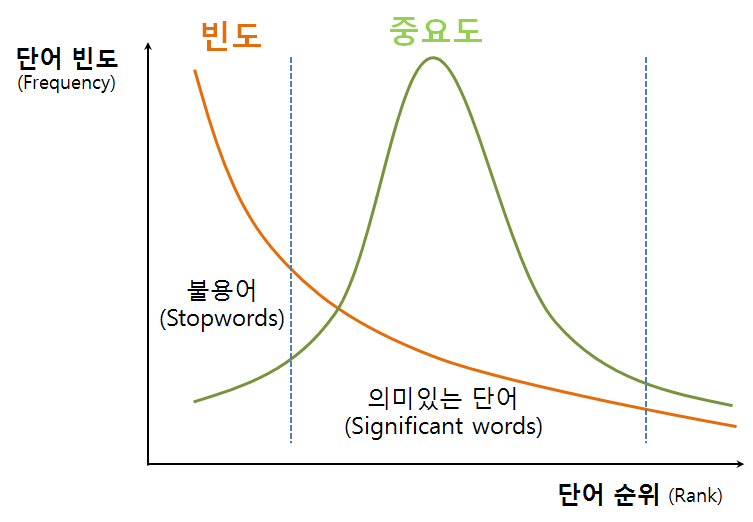

- NLTK의 브라운 말뭉치(Brown Corpus)를 이용해 직접 시험해보자.

In [22]:
nltk.download('brown')
from nltk.corpus import brown

brown.words()[:10], len(brown.words()) # 말뭉치를 토큰화한 결과를 담은 문자열 목록 조회.
# 말뭉치 수가 100만개를 넘음. 자주 쓰이는 것만 뽑아보자.

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\skdbs\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


(['The',
  'Fulton',
  'County',
  'Grand',
  'Jury',
  'said',
  'Friday',
  'an',
  'investigation',
  'of'],
 1161192)

In [26]:
from collections import Counter

puncs = set((',', '.', '--', '-', '!', '?', ':', ';', '``', "''", '(', ')', '[', ']'))
word_list = (x.lower() for x in brown.words() if x not in puncs)
token_counts = Counter(word_list)
token_counts.most_common(20)

[('the', 69971),
 ('of', 36412),
 ('and', 28853),
 ('to', 26158),
 ('a', 23195),
 ('in', 21337),
 ('that', 10594),
 ('is', 10109),
 ('was', 9815),
 ('he', 9548),
 ('for', 9489),
 ('it', 8760),
 ('with', 7289),
 ('as', 7253),
 ('his', 6996),
 ('on', 6741),
 ('be', 6377),
 ('at', 5372),
 ('by', 5306),
 ('i', 5164)]

    1위인 the는 of 보다 약 2배 자주 쓰이고, 3위인 and 보다 약 3배 자주 쓰였음.
    순위와 빈도가 대략 반비례 관계임을 알 수 있다.

# Topic Modeling (주제 모형화)

<br>

- 단어 출현 횟수 TF가 유용하긴 하지만, ***그 자체로는 문서 안에서 단어의 중요도, 다른 문서들에 대한 상대적 중요도를 가늠하기 어려움.***
- 말뭉치에 대한 **한 문서 안에서의 단어의 상대적 중요도를 파악하면 주어진 문서의 말뭉치 안에서의 특징을 서술할 수 있음.**
    - 연에 관한 모든 영어 서적으로 이뤄진 말뭉치를 생각해보자.
    - 말뭉치의 모든 문서에 kite라는 단어가 등장할 것. kite는 이들을 구분하는데 아무런 도움이 X.
    - 하지만 *construction, aerodynamics같은 단어는 일부 책들에만 등장*할 것이고,
    - *그런 단어가 자주 등장하는 문서와 그렇지 않은 문서는 뭔가 다를 것*이다.
- 이런 고찰을 반영하려면 단순한 단어 출현 횟수 TF만으론 부족.
- 이럴때 필요한게 **역문서 빈도 IDF**.
    - ***지프의 법칙을 주제 분석에 적용***하는 수단.
- kite_history를 추가한 예제를 한번 보자.

In [27]:
from nlpia.data.loaders import kite_text, kite_history

kite_intro = kite_text.lower()
intro_tokens = tokenizer.tokenize(kite_intro)
kite_history = kite_history.lower()
history_tokens = tokenizer.tokenize(kite_history)

intro_total = len(intro_tokens)
history_total = len(history_tokens)

intro_total, history_total

(363, 297)

    각 문서에서 kite가 몇번이나 출현하는지 세보자.

In [28]:
intro_tf, history_tf = {}, {}

intro_counts = Counter(intro_tokens)
intro_tf['kite'] = intro_counts['kite'] / intro_total
history_counts = Counter(history_tokens)
history_tf['kite'] = history_counts['kite'] / history_total

print('intro에서의 kite의 Term Frequency는 : {:.4f}'.format(intro_tf['kite']))
print('history에서의 kite의 Term Frequency는 : {:.4f}'.format(history_tf['kite']))

intro에서의 kite의 Term Frequency는 : 0.0441
history에서의 kite의 Term Frequency는 : 0.0202


     두 문서의 출현수는 약 두배 차이.
     그렇다고 intro 문서가 history 문서보다 연에 관한 내용이 2배인 것은 아님.
     
     and는 몇번나오는지도 한번 봐보자.

In [29]:
intro_tf['and'] = intro_counts['and'] / intro_total
history_tf['and'] = history_counts['and'] / history_total
print('intro에서의 and의 Term Frequency는 : {:.4f}'.format(intro_tf['and']))
print('history에서의 and의 Term Frequency는 : {:.4f}'.format(history_tf['and']))

intro에서의 and의 Term Frequency는 : 0.0275
history에서의 and의 Term Frequency는 : 0.0303


    두 문서 모두 and가 kite만큼이나 자주 등장함. 
    그렇다고 and가 kite만큼 중요한 단어는 아님.
    
    주어진 단어가 문서에서 얼마나 중요한지 보기 위해선 IDF가 필요하다.

- 다음 관점에서 생각해보자.
- **이 토큰이 이 문서에 등장한다는 것이 얼마나 이상한 일 일까?**
    - 만일 어떤 용어가 이상하게도 **한 문서에만 나오고, 다른 문서들에는 거의 안나온다면**
    - **그 용어는 그 문서에 있어서 아주 중요한 단어일 것.**
    - 즉, **그 용어는 주제를 말해주는 단어**일 수도 있다.
- 이것이 주제 분석의 첫 걸음.

<br>

- 한 용어의 IDF는 **전체 문서 수를 그 용어가 출현한 문서 수로 나눈 것.**
- IDF라는 **희소성 측도**를 **용어 빈도들에 대한 가중치로 적용**해 볼 수 있다.

In [31]:
num_docs_containing_and = 0
num_docs_containing_kite = 0
num_docs_containing_china = 0
for doc in [intro_tokens, history_tokens]:
    if 'and' in doc:
        num_docs_containing_and += 1
    if 'kite' in doc:
        num_docs_containing_kite += 1
    if 'china' in doc:
        num_docs_containing_china += 1
        
# china의 TF 계산
intro_tf['china'] = intro_counts['china'] / intro_total
history_tf['china'] = history_counts['china'] / history_total

# 세 단어의 IDF 계산.
num_docs = 2
intro_idf, history_idf = {}, {}
intro_idf['and'] = num_docs / num_docs_containing_and
history_idf['and'] = num_docs / num_docs_containing_and
intro_idf['kite'] = num_docs / num_docs_containing_kite
history_idf['kite'] = num_docs / num_docs_containing_kite
intro_idf['china'] = num_docs / num_docs_containing_china
history_idf['china'] = num_docs / num_docs_containing_china

# 각 단어의 TF에 IDF라는 가중치를 곱해 TF-IDF 점수 계산.
intro_tfidf = {}
intro_tfidf['and'] = intro_tf['and'] * intro_idf['and']
intro_tfidf['kite'] = intro_tf['kite'] * intro_idf['kite']
intro_tfidf['china'] = intro_tf['china'] * intro_idf['china']

history_tfidf = {}
history_tfidf['and'] = history_tf['and'] * history_idf['and']
history_tfidf['kite'] = history_tf['kite'] * history_idf['kite']
history_tfidf['china'] = history_tf['china'] * history_idf['china']

intro_tfidf, history_tfidf

({'and': 0.027548209366391185, 'kite': 0.0440771349862259, 'china': 0.0},
 {'and': 0.030303030303030304,
  'kite': 0.020202020202020204,
  'china': 0.020202020202020204})

## Another example (Zipf 재이해)

<br>

- 문서 100만건으로 이뤄진 말뭉치에서 누군가가 cat이라는 단어로 검색했고, 그중 cat이 있는 문서가 단 한개.
    - cat의 IDF는 1,000,000 / 1 = 1,000,000 이 된다.
    - dog이라는 단어가 있는 문서가 10건이면 dog의 IDF는 1,000,000 / 10 = 100,000 이 된다. 
- 지프의 법칙에 따르면 **두 단어의 순위가 멀수록 그 빈도의 차이는 지수적으로 커진다.**
- 즉, ***말뭉치가 크다면 두 단어의 출현 횟수 차이가 그리 크지 않더라도 IDF의 차이는 아주 클 수있다.***
- IDF에 **로그**를 씌우게 되면 두 용어의 IDF를 비교하기 좋을 뿐만 아니라, 전체적인 TF-IDF 점수들이 고르게 분포된다.

<br>

- 그러므로 IDF가 그냥 전체 문서 수 대 단어 출현 문서 수의 비율 (확률)이 아닌, 그 비율의 log라고 정의해보자.
- 상용 로그를 취하게 되면 다음과 같은 수치가 나온다.

    \begin{align}
    IDF(cat) = \log(1000000  /  1) = 6 \\
    IDF(dog) = \log(1000000  /  10) = 5 \\
    \end{align}

<br>

- 주어진 말뭉치 D의 임의의 문서 d와 임의의 단어 t에 대한 TF, IDF, TF-IDF 점수의 정의는 다음과 같다.
    
    \begin{aligned}
    TF(t, d)& = \frac{count(t)}{count(d)} \\
    IDF(t, D)& = \log(\frac{전체 문서 수}{t가 나오는 문서 수}) \\
    TFIDF(t, d, D)& = TF(t, d) * IDF(t, D) \\
    \end{aligned}
 
 <br>
 
- 첫 공식에 따르면, **한 단어가 문서에 자주 나올수록 그 단어의 TF가 올라감.** (TF-IDF도 올라감)
- 두번째 공식에 따르면, **그 단어를 포함한 문서가 많을수록 그 단어의 IDF가 내려감.** (TF-IDF도 내려감)
- **그 둘을 곱하면 TF-IDF 점수**가 나옴. 이는 어떤 수치일까?
    - **특정 단어 또는 토큰을 특정 말뭉치의 특정 문서에 연관시키는 측도.**
    - **주어진 문서에서 그 단어가 얼마나 중요한지를 말뭉치 전체에서의 그 단어의 사용 빈도에 기초해서 추정한 값.**
    
<br>

- 간단한 검색엔진들은 TF-IDF 수치에 기초해 작동한다.

## 관련성 순위

<br>

